# Loan Outcomes Among Pell Grant Recipients: A Comparison of HBCUs and Non-HBCUs

 -----------------------------------------------------------------------
 0. SUPPRESS WARNINGS AND SETUP
 -----------------------------------------------------------------------

In [109]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import re
plt.style.use('tableau-colorblind10')


# 1. INTRODUCTION

This notebook explores how loan default rates, repayment rates, and median debt vary between Historically Black Colleges and Universities (HBCUs) and non-HBCUs, with a focus on Pell Grant recipients. Using institutional-level data, we examine financial outcomes for low-income students and analyze how institutional characteristics influence student borrowing and repayment patterns.

Goals:
- Compare loan default and repayment rates of Pell Grant recipients at HBCUs and non-HBCUs.
- Assess differences in median debt among Pell Grant recipients between HBCUs and non-HBCUs.
- Analyze the relationship between loan amounts and loan outcomes (default and repayment rates), and evaluate whether this relationship varies based on HBCU status.
- Build a predictive model to estimate student loan default risk using synthetic student-level data, incorporating factors such as academic performance, income level, Pell Grant status, and institutional characteristics.

# 2. LOAD AND CLEAN THE DATA

We begin by loading our dataset: 'Most-Recent-Cohorts-Institution.csv'.
Then we select relevant columns, convert columns to numeric where needed,
and clean default rate columns that may contain ranges or inequality signs.

-------------------------------
## 2.1 Load the dataset
-------------------------------

In [110]:
df = pd.read_csv("Most-Recent-Cohorts-Institution.csv")

-------------------------------
## 2.2 Make a copy of the original for reference
-------------------------------

In [111]:
df_original = df.copy()

-------------------------------
## 2.3 Define the columns we want
-------------------------------

In [112]:
COLUMNS = ['HBCU', 'INSTNM', 'BBRR4_FED_PELL_DFLT', 'BBRR4_FED_PELL_PAIDINFULL', 'PELL_DEBT_MDN', 'COSTT4_A', 'ADM_RATE','C150_4_PELL','RET_FT4', 'MD_EARN_WNE_P6'] #overall columns
COLS_TO_BE_CLEANED = ['BBRR4_FED_PELL_DFLT', 'BBRR4_FED_PELL_PAIDINFULL'] #columns that need cleaning

In [113]:
df = df[COLUMNS] #only keep columns needed for analysis

In [114]:
# Convert 'PELL_DEBT_MDN' column to numeric
df['PELL_DEBT_MDN'] = pd.to_numeric(df['PELL_DEBT_MDN'], errors='coerce')
df['COSTT4_A'] = pd.to_numeric(df['COSTT4_A'], errors='coerce')
df['ADM_RATE'] = pd.to_numeric(df['ADM_RATE'], errors='coerce')
df['C150_4_PELL'] = pd.to_numeric(df['C150_4_PELL'], errors='coerce')
df['RET_FT4'] = pd.to_numeric(df['RET_FT4'], errors='coerce')
df['MD_EARN_WNE_P6'] = pd.to_numeric(df['MD_EARN_WNE_P6'], errors='coerce')

-------------------------------
# 2.4 Define a cleaning function
-------------------------------

In [115]:
def clean_bbr_value(x):
    """
    Cleans a default rate value:
      - For ranges (e.g.'0.10-0.14'), calculates the average.
      - For values with inequality symbols, removes the symbols and converts to float.
      - Returns None if the value is missing or cannot be converted.
    """
    if pd.isnull(x):
        return None
    s = str(x).strip()
    if s == '':
        return None
    
    # Handle range: "0.10-0.14"
    if '-' in s:
        parts = re.split(r'\s*-\s*', s)
        if len(parts) == 2:
            try:
                n1 = float(re.sub(r'[^\d\.]', '', parts[0]))
                n2 = float(re.sub(r'[^\d\.]', '', parts[1]))
                return (n1 + n2) / 2
            except Exception:
                return None
                
    # Remove inequality symbols (<=, >=, <, >) and any extraneous characters
    s = re.sub(r'(<=|>=|<|>)', '', s).strip()
    s = re.sub(r'[^\d\.]', '', s)
    try:
        return float(s)
    except Exception:
        return None



-------------------------------
## 2.5 Clean the Pell default and repayment columns
-------------------------------

In [116]:
#apply the cleaning function to columns that require cleaning
for col in COLS_TO_BE_CLEANED:
    df[col] = df[col].apply(clean_bbr_value)

-------------------------------
## 2.6 Rename and drop NaN rows
-------------------------------

In [117]:
df.rename(columns={'BBRR4_FED_PELL_DFLT': 'Default_Rate', 'BBRR4_FED_PELL_PAIDINFULL': 'Repayment_Rate'}, inplace=True)
df.dropna(inplace=True)

-------------------------------
## 2.7 Final DataFrames for each research question
-------------------------------

In [118]:
df_r1 = df.copy()  # For RQ1 (Default and Repayment with HBCU)
df_r2 = df.copy()  # For RQ2 (Median debt for Pell vs. non-Pell)
df_r3 = df.copy()  # For RQ3 (Relation between debt and default/repayment)
df_r4 = df.copy()

# 3. RESEARCH QUESTION 1

Research Question 1:
How does the loan default rate vary between Pell Grant students in HBCUs and 
non-HBCUs, or is it relatively the same across all universities?

Variables:
- Explanatory: University Type (HBCU vs. Non-HBCU)
- Outcome: Loan Default Rate (Default_Rate) and Loan Repayment Rate (Repayment_Rate)
  specifically for Pell Grant students.

-------------------------------
## 3.1 VISUALIZATIONS: Loan Default Rate and Repayment Rate by HBCU vs Non-HBCU for Pell Grant Recipents
-------------------------------

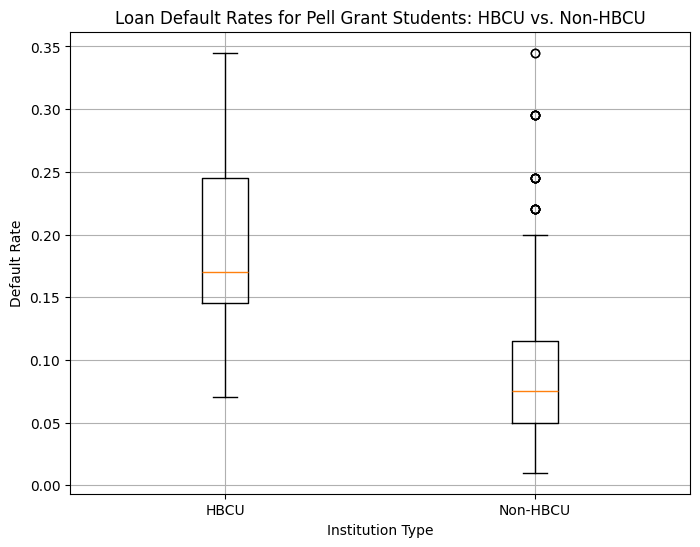

In [119]:
fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This box plot shows the distribution of Pell Grant default rates between HBCU and non-HBCU institutions.
hbcu_defaults = df_r1[df_r1['HBCU'] == 1]['Default_Rate']
non_hbcu_defaults = df_r1[df_r1['HBCU'] == 0]['Default_Rate']

ax.boxplot([hbcu_defaults, non_hbcu_defaults], labels=['HBCU', 'Non-HBCU'])
ax.set_title('Loan Default Rates for Pell Grant Students: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Default Rate')
ax.grid(True)
plt.show()

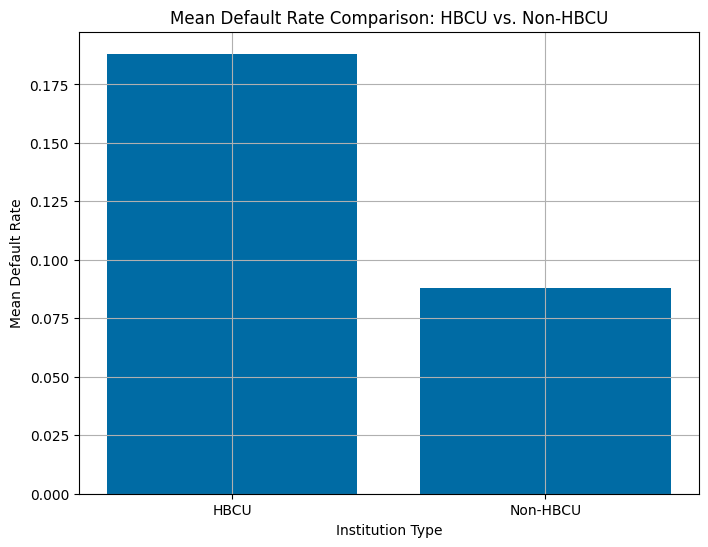

In [120]:
mean_hbcu_default = hbcu_defaults.mean()
mean_non_hbcu_default = non_hbcu_defaults.mean()

fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This bar chart compares the mean Pell Grant default rate for HBCU vs. Non-HBCU institutions.
ax.bar(['HBCU', 'Non-HBCU'], [mean_hbcu_default, mean_non_hbcu_default])
ax.set_title('Mean Default Rate Comparison: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Mean Default Rate')
ax.grid(True)
plt.show()


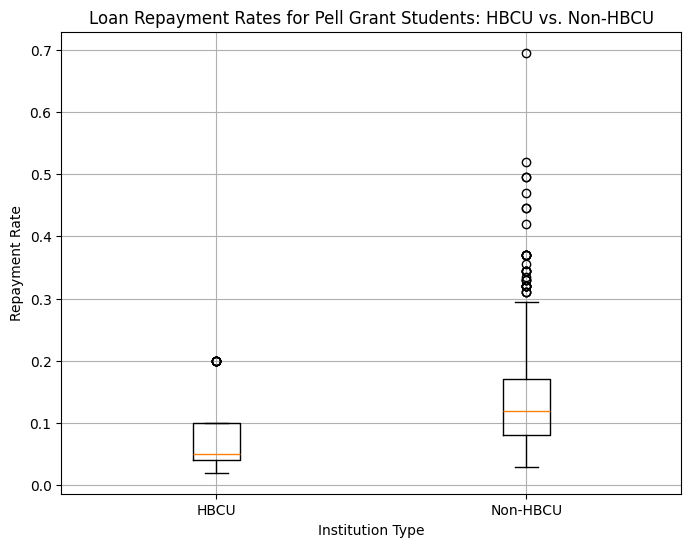

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This box plot shows the distribution of Pell Grant repayment rates between HBCU and non-HBCU institutions.
hbcu_repayments = df_r1[df_r1['HBCU'] == 1]['Repayment_Rate']
non_hbcu_repayments = df_r1[df_r1['HBCU'] == 0]['Repayment_Rate']

ax.boxplot([hbcu_repayments, non_hbcu_repayments], labels=['HBCU', 'Non-HBCU'])
ax.set_title('Loan Repayment Rates for Pell Grant Students: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Repayment Rate')
ax.grid(True)
plt.show()

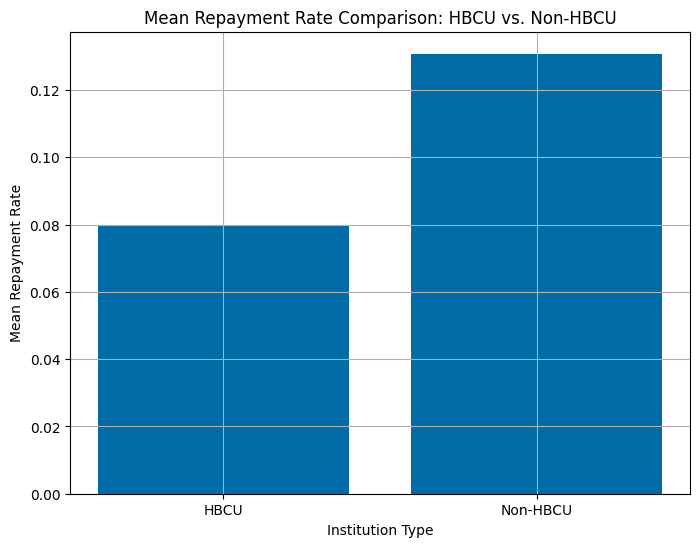

In [122]:
mean_hbcu_repay = hbcu_repayments.mean()
mean_non_hbcu_repay = non_hbcu_repayments.mean()

fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This bar chart compares the mean Pell Grant repayment rate for HBCU vs. Non-HBCU institutions.
ax.bar(['HBCU', 'Non-HBCU'], [mean_hbcu_repay, mean_non_hbcu_repay])
ax.set_title('Mean Repayment Rate Comparison: HBCU vs. Non-HBCU')
ax.set_xlabel('Institution Type')
ax.set_ylabel('Mean Repayment Rate')
ax.grid(True)
plt.show()

-------------------------------
## 3.2 T-test: Compare Pell Default Rate between HBCUs and non-HBCUs
-------------------------------

In [123]:
hbcu_default = df_r1[df_r1['HBCU'] == 1]['Default_Rate']
non_hbcu_default = df_r1[df_r1['HBCU'] == 0]['Default_Rate']

t_stat_default, p_value_default = ttest_ind(hbcu_default, non_hbcu_default, equal_var=False)

print("========================================================")
print("T-test: Pell Grant Default Rate (HBCU vs. Non-HBCU)")
print("========================================================")
print(f"T-statistic: {t_stat_default:.4f}")
print(f"P-value: {p_value_default:.6f}")

T-test: Pell Grant Default Rate (HBCU vs. Non-HBCU)
T-statistic: 11.6236
P-value: 0.000000


-------------------------------
## 3.3 OLS Regression: Default_Rate ~ HBCU
-------------------------------

In [124]:
model_default_ols = smf.ols('Default_Rate ~ HBCU', data=df_r1).fit()

print("\n========================================================")
print("OLS Regression: Default_Rate ~ HBCU")
print("========================================================")
print(model_default_ols.summary())


OLS Regression: Default_Rate ~ HBCU
                            OLS Regression Results                            
Dep. Variable:           Default_Rate   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     227.1
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           9.05e-48
Time:                        18:32:28   Log-Likelihood:                 2355.8
No. Observations:                1445   AIC:                            -4708.
Df Residuals:                    1443   BIC:                            -4697.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

-------------------------------
## 3.4 T-test: Compare Pell Repayment Rate between HBCUs and non-HBCUs
-------------------------------

In [125]:
hbcu_repayment = df_r1[df_r1['HBCU'] == 1]['Repayment_Rate']
non_hbcu_repayment = df_r1[df_r1['HBCU'] == 0]['Repayment_Rate']

t_stat_repay, p_value_repay = ttest_ind(hbcu_repayment, non_hbcu_repayment, equal_var=False)

print("\n========================================================")
print("T-test: Pell Grant Repayment Rate (HBCU vs. Non-HBCU)")
print("========================================================")
print(f"T-statistic: {t_stat_repay:.4f}")
print(f"P-value: {p_value_repay:.6f}")


T-test: Pell Grant Repayment Rate (HBCU vs. Non-HBCU)
T-statistic: -6.2711
P-value: 0.000000


-------------------------------
## 3.5 OLS Regression: Repayment_Rate ~ HBCU
-------------------------------

In [126]:
model_repayment_ols = smf.ols('Repayment_Rate ~ HBCU', data=df_r1).fit()

print("\n========================================================")
print("OLS Regression: Repayment_Rate ~ HBCU")
print("========================================================")
print(model_repayment_ols.summary())


OLS Regression: Repayment_Rate ~ HBCU
                            OLS Regression Results                            
Dep. Variable:         Repayment_Rate   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     28.41
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           1.14e-07
Time:                        18:32:28   Log-Likelihood:                 1832.9
No. Observations:                1445   AIC:                            -3662.
Df Residuals:                    1443   BIC:                            -3651.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

# 4. RESEARCH QUESTION 2

Research Question 2:
How does the loan debt differ by HBCU status?

Variables:
- Explanatory: University Type (HBCU vs. Non-HBCU)
- Outcomes: PELL_DEBT_MDN (median debt for students who received Pell)

In [127]:
# We keep only the relevant columns in df_r2
df_r2 = df_r2[['HBCU', 'INSTNM', 'PELL_DEBT_MDN']]

-------------------------------
## 4.1 Visualization: Pell Debt by HBCU
-------------------------------

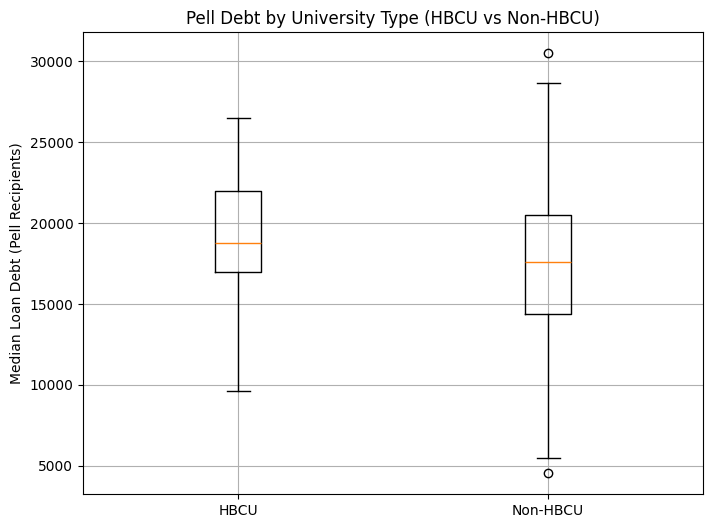

In [128]:
pell_debt_hbcu = df_r2.loc[df_r2['HBCU'] == 1, 'PELL_DEBT_MDN'].dropna()
pell_debt_non_hbcu = df_r2.loc[df_r2['HBCU'] == 0, 'PELL_DEBT_MDN'].dropna()

fig, ax = plt.subplots(figsize=(8, 6))
# alt-text: This box plot shows the distribution of Pell recipients' median debt at HBCU vs. Non-HBCU institutions.
ax.boxplot([pell_debt_hbcu, pell_debt_non_hbcu], labels=['HBCU', 'Non-HBCU'])
ax.set_ylabel("Median Loan Debt (Pell Recipients)")
ax.set_title("Pell Debt by University Type (HBCU vs Non-HBCU)")
ax.grid(True)
plt.show()


-------------------------------
## 4.2 Statistical Test (t-test)
-------------------------------

In [129]:
tstat_pell, pvalue_pell = stats.ttest_ind(pell_debt_hbcu, pell_debt_non_hbcu, equal_var=False)

print("\n========================================================")
print("T-test: PELL_DEBT_MDN (HBCU vs. Non-HBCU)")
print("========================================================")
print(f"T-statistic = {tstat_pell:.3f}")
print(f"P-value     = {pvalue_pell:.3f}")


T-test: PELL_DEBT_MDN (HBCU vs. Non-HBCU)
T-statistic = 3.148
P-value     = 0.003


-------------------------------
## 4.3 Regression Analysis: PELL_DEBT_MDN ~ HBCU
-------------------------------

In [130]:
model_pell = smf.ols("PELL_DEBT_MDN ~ HBCU", data=df_r2).fit()

print("\n========================================================")
print("OLS Regression: PELL_DEBT_MDN ~ HBCU")
print("========================================================")
print(model_pell.summary())


OLS Regression: PELL_DEBT_MDN ~ HBCU
                            OLS Regression Results                            
Dep. Variable:          PELL_DEBT_MDN   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.574
Date:                Fri, 11 Apr 2025   Prob (F-statistic):            0.00600
Time:                        18:32:28   Log-Likelihood:                -14143.
No. Observations:                1445   AIC:                         2.829e+04
Df Residuals:                    1443   BIC:                         2.830e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.

# 5. RESEARCH QUESTION 3

Research Question 3:
How is Pell Grant debt associated with loan default and loan repayment rates, and does this association differ for HBCUs versus non-HBCUs after controlling for other institutional characteristics such as net cost, admissions rate, completion rate, retention rate, and median earnings?

We'll use scatter plots to visualize, and then OLS regressions:
1. Default_Rate ~ PELL_DEBT_MDN + HBCU +  PELL_DEBT_MDN * HBCU + COSTT4_A + ADM_RATE + C150_4_PELL + RET_FT4 + MD_EARN_WNE_P6
2. Repayment_Rate ~ PELL_DEBT_MDN + HBCU +  PELL_DEBT_MDN * HBCU + COSTT4_A + ADM_RATE + C150_4_PELL + RET_FT4 + MD_EARN_WNE_P6

PELL_DEBT_MDN: Median federal debt of Pell Grant recipients at the institution.

HBCU: Indicator variable for whether an institution is a Historically Black College or University.

PELL_DEBT_MDN * HBCU: Interaction term to test if the Pell debt association with outcomes differs by HBCU status.

COSTT4_A: Average annual cost of attendance (includes tuition, fees, books/supplies, and living expenses) for full-time, first-time, degree/certificate-seeking undergraduates who receive Title IV aid.

ADM_RATE / ADM_RATE_ALL: Admissions rate; serves as a proxy for institutional selectivity.

C150_4_PELL: Percentage of Pell Grant recipients who complete their program within 150% of the expected time for a 4-year program).

RET_FT4: Retention rate for full-time students at 4-year institutions.

MD_EARN_WNE_P6: Median earnings of former students 6 years after entry.



-------------------------------
## 5.1 Visualizations of Pell Debt vs. Default Rate/Repayment Rate between HBCU and non-HBCU
-------------------------------

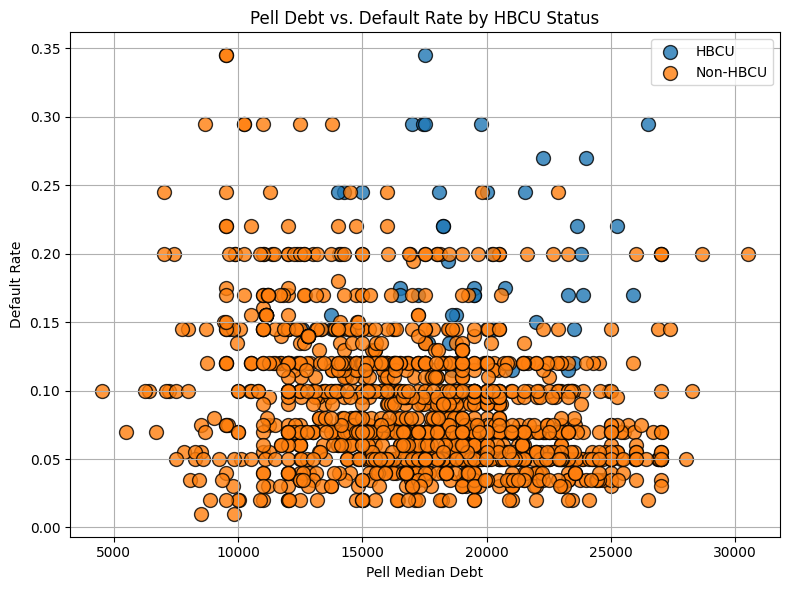

In [131]:
fig, ax = plt.subplots(figsize=(8, 6))

# alt-text: This scatter plot shows Pell median debt (x-axis) versus Pell default rate (y-axis), colored by HBCU status.
hbcu_data = df_r3[df_r3['HBCU'] == 1]
non_hbcu_data = df_r3[df_r3['HBCU'] == 0]

# HBCU points
ax.scatter(hbcu_data['PELL_DEBT_MDN'],hbcu_data['Default_Rate'],label='HBCU',s=100,color='tab:blue',edgecolor='black',alpha=0.8
)

# Non-HBCU points (use orange)
ax.scatter(non_hbcu_data['PELL_DEBT_MDN'],non_hbcu_data['Default_Rate'],label='Non-HBCU',s=100,color='tab:orange',edgecolor='black',alpha=0.8
)

# Labels and title
ax.set_title("Pell Debt vs. Default Rate by HBCU Status")
ax.set_xlabel("Pell Median Debt")
ax.set_ylabel("Default Rate")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


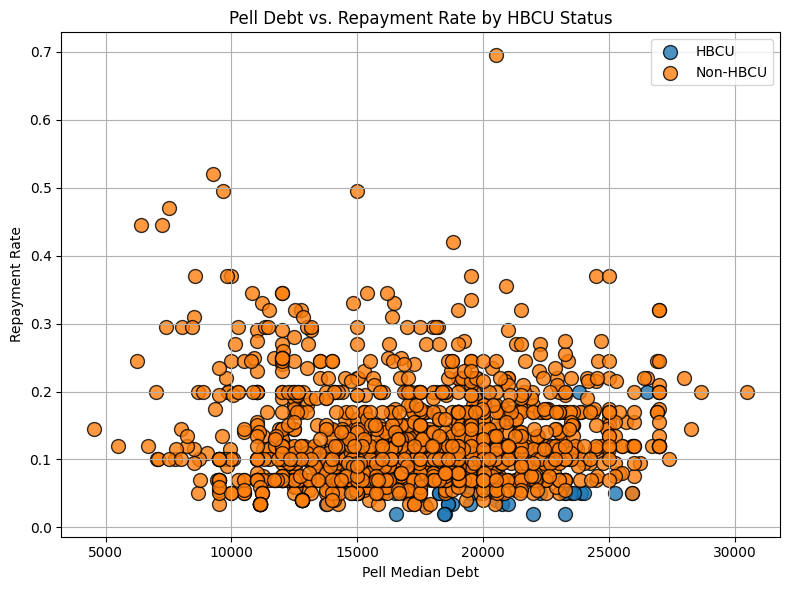

In [132]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# alt-text: This scatter plot shows Pell median debt (x-axis) versus Pell repayment rate (y-axis), colored by HBCU status.

# HBCU points
ax.scatter(hbcu_data['PELL_DEBT_MDN'],hbcu_data['Repayment_Rate'],label='HBCU',s=100,color='tab:blue',edgecolor='black',alpha=0.8
)

# Non-HBCU points
ax.scatter(non_hbcu_data['PELL_DEBT_MDN'],non_hbcu_data['Repayment_Rate'],label='Non-HBCU',s=100,color='tab:orange',edgecolor='black',alpha=0.8
)

# Labels and title
ax.set_title("Pell Debt vs. Repayment Rate by HBCU Status")
ax.set_xlabel("Pell Median Debt")
ax.set_ylabel("Repayment Rate")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


-------------------------------
## 5.2 Regression Analyses
-------------------------------

In [133]:
# Regression for Default Rate predicted by Pell Debt and HBCU
model_default = smf.ols('Default_Rate ~ PELL_DEBT_MDN + HBCU +  (PELL_DEBT_MDN * HBCU) + COSTT4_A + ADM_RATE + C150_4_PELL + RET_FT4 + MD_EARN_WNE_P6', data=df_r3).fit()
print("\n========================================================")
print("OLS Regression: Default_Rate")
print("========================================================")
print(model_default.summary())


OLS Regression: Default_Rate
                            OLS Regression Results                            
Dep. Variable:           Default_Rate   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     175.9
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          7.58e-207
Time:                        18:32:29   Log-Likelihood:                 2743.7
No. Observations:                1445   AIC:                            -5469.
Df Residuals:                    1436   BIC:                            -5422.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [134]:

# Regression for Repayment Rate predicted by Pell Debt and HBCU
model_repayment = smf.ols('Repayment_Rate ~ PELL_DEBT_MDN + HBCU +  (PELL_DEBT_MDN * HBCU) + COSTT4_A + ADM_RATE + C150_4_PELL + RET_FT4 + MD_EARN_WNE_P6', data=df_r3).fit()

print("\n========================================================")
print("OLS Regression: Repayment_Rate")
print("========================================================")
print(model_repayment.summary())


OLS Regression: Repayment_Rate
                            OLS Regression Results                            
Dep. Variable:         Repayment_Rate   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     177.1
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          6.41e-208
Time:                        18:32:29   Log-Likelihood:                 2314.8
No. Observations:                1445   AIC:                            -4612.
Df Residuals:                    1436   BIC:                            -4564.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Inte

# 4. RESEARCH QUESTION 4

## Can we predict loan default risk using student level data?

Since we don’t have access to real student-level data, we generate synthetic data using realistic assumptions. Our goal is to simulate a situation where we could predict whether a student defaults on their loan based on variables related to academic performance, family background, and institutional characteristics.

Variables We Simulate:
- GPA (2.0 – 4.0)
- SAT_Score (national average ~1050, SD ~200)
- Income_Level (1) $0–30,000 (2) $30,001–48,000 (3) $48,001–75,000 (4) $75,001–110,000 (5) $110,000+
- Pell_Recipient (1 if low income, randomly 1/0 otherwise)
- Institution_Type: HBCU (1) or Non-HBCU (0) (15% HBCU, 85% Non-HBCU)

Following Institutional Values generated as random normal based on mean & SD for HBCU and non HBCU differently
- Institution_Net_Cost (COSTT4_A)
- Admission Rate (ADM_RATE)
- Completion Rate (C150_4_PELL)
- Median Earnings After Graduation (MD_EARN_WNE_P6)

We'll also add a Loan_Default variable (binary) generated using a logistic model based on student data.

In [135]:

columns_of_interest = ['COSTT4_A','ADM_RATE','C150_4_PELL','MD_EARN_WNE_P6'] #columns from college scorecard data

# Calculate mean/std for HBCU and non-HBCU differently
group_stats = df_r4.groupby('HBCU')[columns_of_interest].agg(['mean','std'])

# store the values for each feature as dictionary: stats_dict[hbcu_value][column] = (mean, std) 0:Non-HBCU, 1: HBCU 
stats_dict = {0.0: {}, 1.0: {}}
for hbcu_val in [0.0, 1.0]:
    for col in columns_of_interest:
        mean_val = group_stats.loc[hbcu_val, (col, 'mean')]
        std_val = group_stats.loc[hbcu_val, (col, 'std')]

        if pd.isna(std_val) or std_val == 0:
            std_val = 1.0  #if std value is invalid

        stats_dict[hbcu_val][col] = (mean_val, std_val)

#syntheic data for students
num_students = 10000

# Student level data that is independent of HBCU/non-HBCU group
gpa = np.round(np.clip(np.random.normal(3.0, 0.5, num_students), 2.0, 4.0), 2)
sat_score = np.clip(np.round(np.random.normal(1050, 200, num_students)), 400, 1600)
income_levels = ['$0-$30,000', '$30,001-$48,000', '$48,001-$75,000', '$75,001-$110,000', '$110,000+']
income_level = np.random.choice(income_levels, size=num_students, p=[0.3, 0.25, 0.2, 0.15, 0.1])

pell_recipient = np.where(income_level == '$0-$30,000', np.random.choice([1, 0], size=num_students, p=[0.9, 0.1]), np.random.choice([1, 0], size=num_students, p=[0.2, 0.8]))

# Randomly assign HBCU vs. Non-HBCU for each student, 15% chance HBCU, 85% chance Non-HBCU 
hbcu_assignments = np.random.choice([0.0, 1.0], size=num_students, p=[0.85, 0.15])

# generate random normal values for the institutional variables for each student
student_dict = {'GPA': gpa, 'SAT_Score': sat_score, 'Income_Level': income_level, 'Pell_Recipient': pell_recipient, 'HBCU': hbcu_assignments}

# institutional field is assigned to students based on HBCU/Non-HBCU:
for col in columns_of_interest:
    values = []
    for i in range(num_students):
        group_val = hbcu_assignments[i]  # 0 or 1
        mean_val, std_val = stats_dict[group_val][col]
        
        val = np.random.normal(mean_val, std_val) #draw the value from normal distribution
        values.append(val)

    student_dict[col] = values

# synthetic DataFrame
synthetic_df = pd.DataFrame(student_dict)

# clip to prevent negative values
synthetic_df['COSTT4_A'] = synthetic_df['COSTT4_A'].clip(lower=0)
synthetic_df['ADM_RATE'] = synthetic_df['ADM_RATE'].clip(lower=0)
synthetic_df['C150_4_PELL'] = synthetic_df['C150_4_PELL'].clip(lower=0)
synthetic_df['MD_EARN_WNE_P6'] = synthetic_df['MD_EARN_WNE_P6'].clip(lower=0)

print(synthetic_df.describe()) #get synthetic df info


                GPA     SAT_Score  Pell_Recipient          HBCU  \
count  10000.000000  10000.000000    10000.000000  10000.000000   
mean       3.007914   1046.633400        0.405100      0.149600   
std        0.482636    198.451159        0.490936      0.356697   
min        2.000000    400.000000        0.000000      0.000000   
25%        2.660000    912.000000        0.000000      0.000000   
50%        3.010000   1046.000000        0.000000      0.000000   
75%        3.350000   1181.000000        1.000000      0.000000   
max        4.000000   1600.000000        1.000000      1.000000   

            COSTT4_A      ADM_RATE   C150_4_PELL  MD_EARN_WNE_P6  
count   10000.000000  10000.000000  10000.000000    10000.000000  
mean    39605.490713      0.724632      0.513483    45922.252494  
std     17637.423663      0.212872      0.188850    12830.670685  
min         0.000000      0.000000      0.000000        0.000000  
25%     27008.957581      0.578178      0.385244    36053.676

In [136]:

# Create logistic function

le = LabelEncoder()
synthetic_df['Income_Level_Encoded'] = le.fit_transform(synthetic_df['Income_Level']) #convert to ordinal

# Generate  log-odds for default risk
log_odds = (
    -3
    + (2.50 - synthetic_df['GPA'])
    + 0.00015 * synthetic_df['COSTT4_A']
    + 0.25 * (4 - synthetic_df['Income_Level_Encoded'])
    + 0.40 * synthetic_df['Pell_Recipient']
    + 0.40 * synthetic_df['HBCU']
)

# Log odds to probabability using sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

prob_default = sigmoid(log_odds)

# use the probablility to generate binary value for if the loan defaulted
np.random.seed(123)
synthetic_df['Loan_Default'] = np.random.binomial(1, prob_default)

In [137]:
# Logistic Regression Model training

X = synthetic_df[['GPA', 'SAT_Score', 'Income_Level_Encoded', 'Pell_Recipient', 'HBCU',
            'COSTT4_A', 'ADM_RATE', 'C150_4_PELL', 'MD_EARN_WNE_P6']].copy()
X['HBCU'] = X['HBCU'].astype(int)

y = synthetic_df['Loan_Default']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

# logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# model evaluation
print("Classification Report:", classification_report(y_test, y_pred))

# model coefficients
coef_df = pd.DataFrame({'Feature': X.columns,'Coefficient': model.coef_[0]})
print("Logistic Model Coefficients:", coef_df)

Classification Report:               precision    recall  f1-score   support

           0       0.76      0.54      0.63       461
           1       0.92      0.97      0.94      2539

    accuracy                           0.90      3000
   macro avg       0.84      0.75      0.79      3000
weighted avg       0.90      0.90      0.90      3000

Logistic Model Coefficients:                 Feature  Coefficient
0                   GPA    -0.913842
1             SAT_Score     0.000006
2  Income_Level_Encoded    -0.230904
3        Pell_Recipient     0.432695
4                  HBCU     0.517635
5              COSTT4_A     0.000154
6              ADM_RATE    -0.417509
7           C150_4_PELL     0.093356
8        MD_EARN_WNE_P6     0.000006
